# Исследование успешности компьютерных игр

На основе исторических данных о продажах игр, оценки пользователей и экспертов, жанры и платформы необходимо выявить закономерности, определяющие успешность игры. 

**План исследования**
1. [Загрузка данных](#start)
2. [Подготовка данных](#start_p)
2. [Исследовательский анализ данных](#eda)
3. [Портрет пользователя каждого региона](#region)
4. [Проверка гипотез](#hypothesis)
5. [Общий вывод](#conclusion)

# Шаг 1. Загрузка данных <a id='start'></a>

In [1]:
# импорт библиотек 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from IPython.display import display
import warnings
warnings.simplefilter("ignore")

Прочитаем файл /datasets/games.csv и сохраним его в переменной games_data.

In [2]:
games_data_real = pd.read_csv('games.csv') # чтение файла с данными
games_data = games_data_real.copy() # копия датафрейма
games_data.head(5) # получение первых строк таблицы

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games_data.info() # общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Таблица состоит из 16715 строк и 11 столбцов:
Name — название игры (тип object),
Platform — платформа (тип object),
Year_of_Release — год выпуска (тип float64),
Genre — жанр игры (тип object),
NA_sales — продажи в Северной Америке (миллионы долларов) (тип float64),
EU_sales — продажи в Европе (миллионы долларов) (тип float64),
JP_sales — продажи в Японии (миллионы долларов) (тип float64),
Other_sales — продажи в других странах (миллионы долларов) (тип float64),
Critic_Score — оценка критиков (максимум 100) (тип float64),
User_Score — оценка пользователей (максимум 10) (тип object),
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию (тип object).

Заметим, что данные неполные, так как есть пропуски.

# Шаг 2. Подготовка данных <a id='start_p'></a>

## Замена названия столбцов 

In [4]:
#Приведем названия столбцов к нижнему регистру
games_data.columns = games_data.columns.str.lower()
games_data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

## Обработка пропусков

Рассмотрим пропуски, а также проверим данные на наличие дубликатов.

In [5]:
games_data.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

#### Пропуски в name и genre

In [6]:
# Рассмотри две строки с пропусками в 'name'
games_data[games_data['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Заметим, что в этих же строках пропуски в столбце 'genre'. Удалим две строки, которые одновременно содержат пропуски в 'name' и 'genre'.

In [7]:
#удаление строк с пропусками
games_data.dropna(subset=['name'],inplace=True)

In [8]:
# Проверка, что нет пропусков
print(games_data['name'].isnull().sum())
print(games_data['genre'].isnull().sum())

0
0


#### Пропуски в year_of_release 

In [9]:
# Проверка, наличия пропусков
games_data['year_of_release'].isnull().sum()

269

Так как далее в анализе необходимо будет делать распределение по годам, выделить актуальный период, то строки с пропусками логичнее удалить из рассмотрения. К тому же в исходной таблице нет дополнительных данных, по которым мы могли бы определить хотя бы примерный год выпуска игры. 269 строк - это 1,6% общих данных, не критичный объем данных для удаления.

In [10]:
# Удаление строк с пропусками
games_data.dropna(subset=['year_of_release'],inplace=True)

In [11]:
# Проверка, что нет пропусков
games_data['year_of_release'].isnull().sum()

0

#### Пропуски в critic_score и user_score

In [12]:
# Рассмотрим данные в столбце critic_score
games_data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [13]:
# Рассмотрим данные в столбце user_score
games_data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Пропусков в critic_score (8578) и user_score (6701) достаточно много и они представляют собой количественные переменные. Можно предположить, что данные пропуски говорят о том, что данная игра не участвовала в рейтингах, игра не была рассмотрена аудиторией и критиками. 
Поэтому заполнять пропуски не стоит. К тому же в дальнейшем анализе эту информацию нужно будет вставлять в стат-тест и любые искусственно-сгенерированные значения могут исказить результат теста.

Заметим, что в оценке пользователей user_score встречается значение 'tbd'. Данная аббревиатура не скрывает в себе никаких таинственных смыслов и расшифровывается очень просто - To Be Determined, то есть "Будет определено". Т.е. игра отправлена на рейтинг, но пока еще точный рейтинг неизвестен.

In [14]:
games_data.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Строк со значением 'tbd' довольно много. Не будем удалять эти значения, но заменим их на Nan (с вещественным типом), чтобы потом со стат-тестами и корреляцией не мешали работать.

In [15]:
games_data.loc[games_data['user_score'] == 'tbd', 'user_score'] = float('nan')

#### Пропуски в rating

In [16]:
# Все уникальные значения в столбце
games_data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

В данных есть пропуски, а сами значения, встречающиеся в столбце - категориальные переменные. В рейтинге rating пропуски заменим на специальное значение 'unknown'.

In [17]:
games_data['rating'] = games_data['rating'].fillna('unknown')
games_data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

ESRB — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию:
«EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет;
«E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет и старше (Первоначально "K-A" ("Kids to Adults"));
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»;
«T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше;
«M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет; 
«AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет;
«RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. 

В данных есть значение Е и значение К-А, хотя это одно и тоже. Поэтому заменим старую аббревиатура К-А на новую Е.

In [18]:
games_data['rating'] = games_data['rating'].replace('K-A','E')
games_data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

Итоговые данные о пропусках.

In [19]:
games_data.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

Установим наличие дубликатов. 

In [20]:
print(games_data.duplicated().sum())
#получение суммарного количества дубликатов в таблице data

0


Дубликатов нет.

Итак, были рассмотрены все пропуски в данных. Строки с пропусками в столбцах name, genre, year_of_release были удалены (их процент довольно мал). 

Пропуски в столбцах critic_score и user_score оставили, так как их очень много,к тому же в дальнейшем анализе эту информацию нужно будет вставлять в стат-тест и любые искусственно-сгенерированные значения могут исказить результат теста. В оценке пользователей user_score встречается значение 'tbd',т.е. оценка только "Будет определена". Эти значения заменили на Nan, чтобы потом со стат-тестами и корреляцией не мешали работать.

В столбце рейтинга rating пропуски заменили на специальное значение 'unknown' (категориальные данные). Заменили в данных старую аббревиатуру из ESRB К-А на новую Е.

Строк со значением 'tbd' довольно много. Не будем удалять эти значения, но заменим их на Nan, чтобы потом со стат-тестами и корреляцией не мешали работать.

Дубликатов в данных нет.


## Замена типа данных <a id='repl'></a>

Рассмотрим типы данных.

In [21]:
games_data.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

name — название игры (тип object),
platform — платформа (тип object),
year_of_release — год выпуска (тип float64),
genre — жанр игры (тип object),
na_sales — продажи в Северной Америке (миллионы долларов) (тип float64),
eu_sales — продажи в Европе (миллионы долларов) (тип float64),
jp_sales — продажи в Японии (миллионы долларов) (тип float64),
other_sales — продажи в других странах (миллионы долларов) (тип float64),
critic_score — оценка критиков (максимум 100) (тип float64),
user_score — оценка пользователей (максимум 10) (тип object), 
Rating — рейтинг от организации ESRB. Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию (тип object).

Тип данных в столбце user_score - object (строка), заменим на вещественный тип данных.

In [22]:
games_data['user_score'] = games_data['user_score'].astype('float')

Рассмотрим данные в столбце year_of_release.

In [23]:
games_data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000., 1995., 1991., 1981., 1987., 1980.,
       1983.])

Заменим вещественный тип данных на целочисленный в столбце year_of_release.

In [24]:
games_data['year_of_release'] = games_data['year_of_release'].astype('int')

Остальные типы данных выглядят корректтно.

In [25]:
# Проверка замены типа данных
games_data.dtypes

name                object
platform            object
year_of_release      int32
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

Сделали замену типов данных в двух столбцах: в столбце user_score заменили на вещественный тип данных,  в столбце year_of_release на целочисленный.

## Суммарные продажи во всех регионах 

Создадим новый столбец с суммарной продажей во всех регионах. Для этого сложим столбцы продаж по каждому выделенному региону.

In [26]:
games_data['total_sales'] = games_data['na_sales'] + games_data['eu_sales'] + games_data['jp_sales'] + games_data['other_sales']
games_data[['na_sales','eu_sales','jp_sales','other_sales','total_sales']].sample(5)

,na_sales,eu_sales,jp_sales,other_sales,total_sales
6833,0.10,0.10,0.00,0.04,0.24
3649,0.21,0.27,0.00,0.06,0.54
3928,0.37,0.11,0.00,0.02,0.50
9071,0.09,0.04,0.00,0.01,0.14
10304,0.00,0.00,0.11,0.00,0.11


# Шаг 3. Исследовательский анализ данных  <a id='eda'></a>

## Годовое количество игр

Составим таблицу, в которой соберем данные о том сколько игр было выпущено за каждый год.

In [27]:
year_games = games_data.pivot_table(
               index='year_of_release',
               values='name',
               aggfunc='count').rename(columns={'name':'count_game'})
year_games

,count_game
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


Представим информацию графически, постороим график выпуска игр по годам.

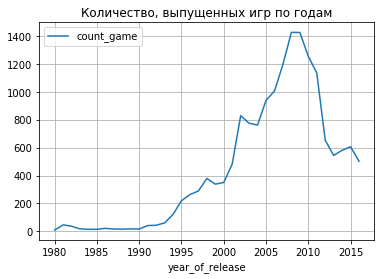

In [28]:
year_games.plot(grid=True)
plt.title('Количество, выпущенных игр по годам')
plt.show()


Заметим, что были периоды, где количество игр было очень мало. Отбросим года, где среднее значение выпуска игр меньше среднего.

In [29]:
year_games.describe().loc['mean']

count_game    444.432432
Name: mean, dtype: float64

С 2001 года стало выпускаться не менее 444 игр ежегодно. Поэтому период до 2001 года можно откинуть по малому количеству игр.
Сохраним начало периода существееных лет в переменную level_year, т.е. значение 2001.

In [30]:
level_year = 2001

## Анализ продаж по платформам

Найдем платформы с наибольшими суммарными продажами (топ-5)

In [31]:
# группируем данные по наименованию платформы, подсчитываем для каждой платформы суммарную продажу, сорттируем данные
# по убыванию столбца суммарных продаж. Сохраняем в таблицу топ-5 строк
platforms_top = (games_data.query('year_of_release>=@level_year')
                  .pivot_table(index='platform',values='total_sales',aggfunc='sum')
                  .sort_values(by='total_sales',ascending=False)
                  .head()
                 )
platforms_top

,total_sales
platform,
PS2,1194.39
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76


Итак, это платформы 'PS2', 'X360', 'Wii', 'PS3', 'DS'.

Построим распределение по существенным годам для каждой платформы из топ-5.

In [32]:
games_data[(games_data['platform'].isin(platforms_top.index))&(games_data['year_of_release']>=level_year)].pivot_table(
    index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

platform,DS,PS2,PS3,Wii,X360
year_of_release,,,,,
2001,NaN,166.43,NaN,NaN,NaN
2002,NaN,205.38,NaN,NaN,NaN
2003,NaN,184.31,NaN,NaN,NaN
2004,17.27,211.81,NaN,NaN,NaN
2005,130.14,160.66,NaN,NaN,8.25
2006,119.81,103.42,20.96,137.15,51.62
2007,146.94,75.99,73.19,152.77,95.41
2008,145.31,53.90,118.52,171.32,135.26
2009,119.54,26.40,130.93,206.97,120.29


Построим для наглядности графики по этим данным.

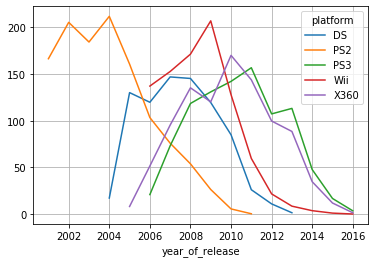

In [33]:
pd.pivot_table(games_data[(games_data['platform'].isin(platforms_top.index))&(games_data['year_of_release']>=level_year)],
               index='year_of_release',
               columns='platform',
               values='total_sales',
               aggfunc='sum').plot(grid=True)
plt.show()

Заметим, что у любой платформы есть периоды роста, пика и спада продаж. Посчитаем сколько в среднем длится жизненный цикл платформы, т.е. характерный срок появления новых и исчезновения старых платформ. Создадим таблицу по всем платформам, отображающую средние продажи по всем годам.

In [34]:
# таблица по всем платформам
longevity_data = games_data.pivot_table(index='platform',columns='year_of_release',values='total_sales',aggfunc='sum')

Дополнительно введем пороговое значение значительных суммарных продаж - level, чтобы исключить года, где продажи игр ничтожно малы.
Подсчитаем в столбце longevity количество лет с продажами выше порога для каждой платформы.

In [35]:
level = 10.0

def longevity(value):
    i=0
    for year in value:
        if year >= level:
            i+=1
    return i
 
#На вход функции попадает строка со значениями продаж по годам, 
# а возвращает она количество лет со значением продаж выше порогового.
#Используется правило: 
# по каждой платформе перебираются все года и суммируется кол-во лет, в которых значением продаж выше порогового level

longevity_data['longevity'] = longevity_data.apply(longevity,axis=1)    
longevity_data.head()

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,longevity
platform,,,,,,,,,,,,,,,,,,,,,
2600,11.38,35.68,28.88,5.84,0.27,0.45,0.67,1.94,0.74,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14,6
DC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
DS,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,...,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN,9


По полученным данным найдем средний жизненный цикл платформ, используя describe(). Предварительно убрав из данных строки, в которых в столбе longevity нулевое значение (т.е. отсутствуют года с продажами выше порога), так как они повлияю на расчет среднего.

In [36]:
longevity_data = longevity_data.query('longevity !=0') # убираем строки с нулевыми значениями
print(longevity_data['longevity'].describe()) #- вывод числовых показателей жизненного цикла платформ

count    23.000000
mean      6.086957
std       2.778375
min       1.000000
25%       4.000000
50%       6.000000
75%       7.000000
max      11.000000
Name: longevity, dtype: float64


Получаем, что характерный срок, за который появляются новые и исчезают старые платформы, равен 6 годам.

Итак, платформы 'PS2', 'X360', 'PS3', 'Wii', 'DS' имеют наибольшие суммарные продажи. У любой платформы есть периоды роста, пика и спада продаж. Характерный срок, за который появляются новые и исчезают старые платформы, равен 6 годам.


## Отбор данных за актуальный период. 

Заметим, что по состоянию на 2016 год многие платформы исчезли. Так из рассмотренных топ-5 платформ в 2016 году осталось только 3. Создадим новую таблицу с данными за 2016 год,т.е. выберем платформы, на которых выпускались игры в 2016 году.

In [37]:
games_data_2016 = games_data.query('year_of_release == 2016')

## Поиск потенциально прибыльных платформ

Выберем топ-5 платформ,лидирующих по продажам.

In [38]:
# группируем данные по наименованию платформы, подсчитываем для каждой платформы суммарную продажу, сорттируем данные
# по убыванию столбца суммарных продаж. Сохраняем в таблицу топ-5 строк
platforms_top_2016 = (games_data_2016
                  .pivot_table(index='platform',values='total_sales',aggfunc='sum')
                  .sort_values(by='total_sales',ascending=False)
                  .head()
                 )
platforms_top_2016.index

Index(['PS4', 'XOne', '3DS', 'PC', 'WiiU'], dtype='object', name='platform')

Платформы 'PS4', 'XOne', '3DS', 'PC', 'WiiU' лидируют по продажам. Рассмотрим суммарные продажи по этим платформам в динамике. Построим график суммарных продаж по изучаемым платформам по всем годам.

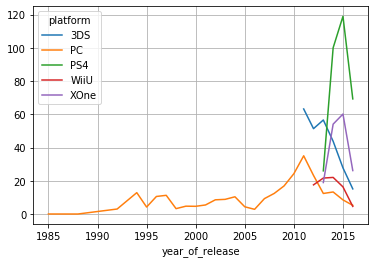

In [39]:
pd.pivot_table(games_data[(games_data['platform'].isin(platforms_top_2016.index))],
               index='year_of_release',
               columns='platform',
               values='total_sales',
               aggfunc='sum').plot(grid=True)
plt.show()

Как видно из графиков, по состоянию на 2016 год все указанные выше платформы падают. У платформ PS4 и XOne пик продаж наблюдался совсем недавно, в 2015 году. И хотя у платформы PC наблюдается спад продаж, но она самая долгая из топ-платформ, появилась еще в 1985 году.

Примем за актуальный период с 2011 по 2016 год и найдем потенциально прибыльные платформы, т.е. платформы у которых наблюдается рост продаж.

In [40]:
# создаем таблицу с данными только за актуальный период
actual_games_data = games_data.query('2011<=year_of_release<=2016')

In [41]:
pd.pivot_table(actual_games_data, index='year_of_release',
               columns='platform',
               values='total_sales',
               aggfunc='sum')

platform,3DS,DS,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,,
2011,63.20,26.18,35.03,0.45,156.78,NaN,17.82,4.63,59.65,NaN,143.84,NaN
2012,51.36,11.01,23.22,NaN,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,NaN,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,NaN,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,NaN,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,NaN,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


Заметим, что 2015 год был пиковым по продажам на многих платформах. Все значения продаж в 2016 году меньше, чем в 2015. Это не обязательно говорит о спаде продаж по конкретной платформе, возможно на бум продаж в 2015 году (или резкий спад в 2016) сыграли внешние факторы. Все же можно выделить потенциально прибыльные платформы, для которых до 2015 года наблюдался рост продаж. Это PS4 и XOne.

Итак, по состоянию на 2017 год платформы 'PS4', 'XOne', '3DS', 'PC', 'WiiU' лидируют по продажам. Можно выделить потенциально прибыльные платформы, для которых ранее наблюдался рост продаж - это PS4 и XOne. К потенциально прибыльным платформам можно еще отнести платформу PC, так как она входит в топ прибыльных платформ, к тожу же она самая долгая из топ-платформ, появилась еще в 1985 году, возможно она еще долго продержится на рынке.

## Сравнение глобальных продаж каждой игры и с разбивкой по платформам. 

 Игр в данных очень много, поэтому отберем только игры с максимальными продажами за актуальный период.

In [42]:
# группируем данные по названию игры, у которой суммарная продажа больше значения level,
# подсчитываем для каждой игры суммарную продажу, сорттируем данные
# по убыванию столбца суммарных продаж.

games_top = (actual_games_data.query('total_sales>@level')
                  .pivot_table(index='name',values='total_sales',aggfunc='sum')
                  .sort_values(by='total_sales',ascending=False)
                 )
games_top.head()

,total_sales
name,
Grand Theft Auto V,49.94
Call of Duty: Modern Warfare 3,28.06
Call of Duty: Black Ops II,27.47
Call of Duty: Black Ops 3,14.63
Pokemon X/Pokemon Y,14.60


Строим график «ящик с усами» по глобальным продажам каждой игры (в которой суммарная продажа больше значения порогового значения) и с разбивкой по топ-платформам.

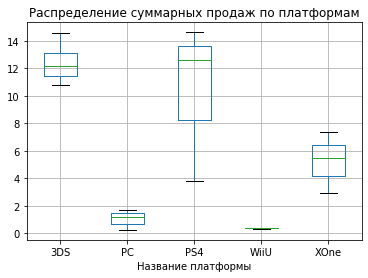

In [43]:
pd.pivot_table(actual_games_data[(actual_games_data['platform'].isin(platforms_top_2016.index))
                                 &(actual_games_data['name'].isin(games_top.index))],
               index='name',
               columns='platform',
               values='total_sales',
               aggfunc='sum').boxplot()
plt.xlabel('Название платформы')
plt.title('Распределение суммарных продаж по платформам')
plt.show()

Рассматривая распределение суммарных продаж по платформам, можно заметить, что большую прибыль приносят платформы 3DS,PS4,XOne.

Теперь сравним полученные результаты с данными по средним продажам на разных платформах по всем играм.

Для каждой платформы найдем среднее значение продаж по играм (в которой суммарная продажа больше значения порогового значения).

In [44]:
pd.pivot_table(actual_games_data[actual_games_data['name'].isin(games_top.index)],
               index='platform',
               values='total_sales',
               aggfunc='mean').sort_values(by='total_sales',ascending=False)

,total_sales
platform,
3DS,12.435000
PS4,10.360000
PS3,9.973333
X360,9.773333
Wii,5.475000
XOne,5.260000
PC,1.070000
WiiU,0.380000


В средних продажах на разных платформах, как и в глобальным продажам каждой игры (в которой суммарная продажа больше значения порогового значения) с разбивкой по топ-платформам сохраняется тенденция, что наибольша прибыль у платформы 3DS, затем идет PS4, затем - XOne, затем - PC, в конце - WiiU.

## Влияние отзывов пользователей и критиков на продажи внутри одной популярной платформы. 

Рассмотрим самую популярную платформу за 2016 год - PS4. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

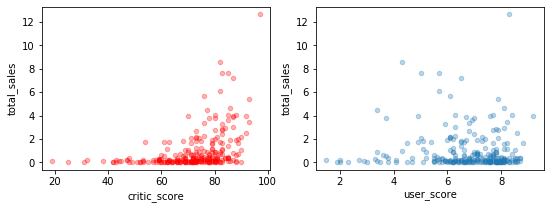

Корреляция между отзывами критиков и продажами 0.40656790206178145
Корреляция между отзывами пользователей и продажами -0.03195711020455646


In [45]:
plt.subplots(figsize=(9,3)) # создание таблицы для отрисовки графиков вместе
actual_games_data.query('platform=="PS4"').plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3,color='red'
                                         ,ax=plt.subplot(1,2,1)) #график отзывов критиков
actual_games_data.query('platform=="PS4"').plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3
                                         ,ax=plt.subplot(1,2,2)) #график отзывов пользователей

plt.show()

games_data_ps4 = actual_games_data.query('platform=="PS4"') # создаем таблицу с данными по платформе PS4
print('Корреляция между отзывами критиков и продажами',games_data_ps4['critic_score']
      .corr(games_data_ps4['total_sales']))
print('Корреляция между отзывами пользователей и продажами',games_data_ps4['user_score']
      .corr(games_data_ps4['total_sales']))

Корреляция в 0,4 говорит о наличии малой связи между отзывами критиков и продажами. Выходит, положительный отзыв критиков приводит к увеличению продаж, но так бывает далеко не всегда. Корреляция в -0,03 говорит об отсутствие связи между отзывами пользователей и продажами. Получается, что отзывы пользователей никак не влияют на продажи игр. Диаграммы рассеяния подтерждают наши выводы.

## Влияние отзывов пользователей и критиков на продажи игр на других платформах.

Теперь построим диаграммы рассеяния и посчитаем корреляции между отзывами и продажами игр на других популярных платформах.

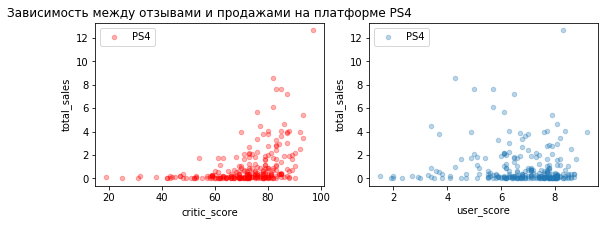

Корреляция между отзывами критиков и продажами 0.40656790206178145
Корреляция между отзывами пользователей и продажами -0.03195711020455646


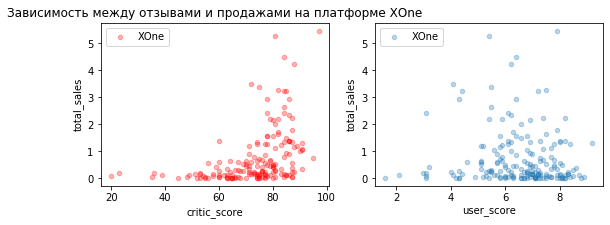

Корреляция между отзывами критиков и продажами 0.4169983280084016
Корреляция между отзывами пользователей и продажами -0.0689250532827942


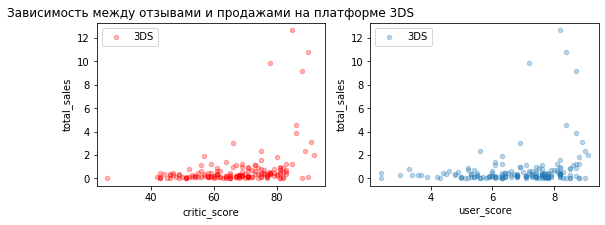

Корреляция между отзывами критиков и продажами 0.34873973059848346
Корреляция между отзывами пользователей и продажами 0.22207843643390893


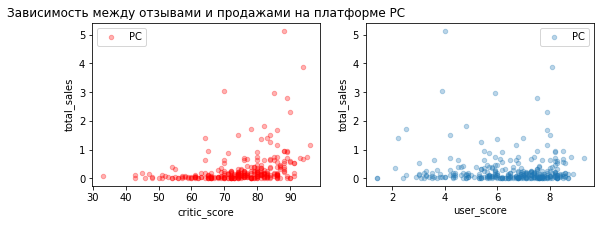

Корреляция между отзывами критиков и продажами 0.3141847396903632
Корреляция между отзывами пользователей и продажами -0.04896683233511957


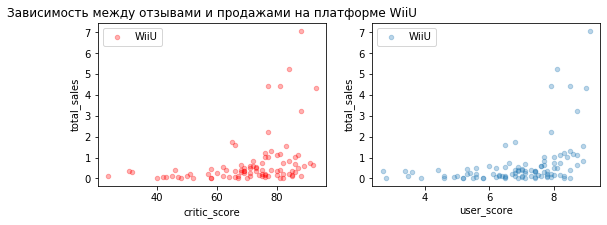

Корреляция между отзывами критиков и продажами 0.3483797601201749
Корреляция между отзывами пользователей и продажами 0.4002190202148619


In [46]:
# В цикле для каждой популярной платформы построим диаграммы рассеяния и посчитаем корреляции между отзывами и продажами игр
#
for platform in platforms_top_2016.index:
    plt.subplots(figsize=(9,3)) # создание таблицы для отрисовки графиков вместе
    actual_games_data.query('platform == @platform').plot(x='critic_score',
                                                                  y='total_sales', color='red',
                                                                  kind='scatter', alpha=0.3, label=platform,
                                                   ax=plt.subplot(1,2,1))
    plt.title('Зависимость между отзывами и продажами на платформе '+platform)
    actual_games_data.query('platform == @platform').plot(x='user_score',
                                                                  y='total_sales', label=platform,
                                                                  kind='scatter', alpha=0.3, 
                                                   ax=plt.subplot(1,2,2))
    
    plt.show()
    
    games_data_i = actual_games_data.query('platform==@platform')
    print('Корреляция между отзывами критиков и продажами',games_data_i['critic_score'].corr(games_data_i['total_sales']))
    print('Корреляция между отзывами пользователей и продажами',games_data_i['user_score'].corr(games_data_i['total_sales']))

По всем популярным платформам  наблюдается наличие очень малой связи между отзывами критиков и продажами. Т.е. отзывы критиков хоть и влияют на продажи игр, но очень несущественно.
На платформах PS4, XOne, 3DS, PC наблюдается отсутствие связи между отзывами пользователей и продажами. Получается, что отзывы пользователей никак не влияют на продажи игр. А вот на платформе WiiU наблюдается наличие связи между отзывами пользователей и продажами, но довольно небольшое.

Диаграммы рассеяния подтерждают наши выводы.

## Самые прибыльные жанры

Рассмотрим игры каких жанров выпускаются чаще остальных за актуальный период.

In [47]:
# создаем таблицу с данными о количестве игр по жанрам
genre_percent = actual_games_data.pivot_table(index='genre',
               values='name',
               aggfunc='count').rename(columns={'name':'count_game'}).sort_values('count_game',ascending=False)
# создаем столбец percent,для отображения процентного распределения игр по жанрам. Округляем значение до сотых.
genre_percent['percent'] = round((genre_percent['count_game'] / genre_percent['count_game'].sum() * 100),2)
genre_percent

,count_game,percent
genre,,
Action,1269,31.55
Role-Playing,465,11.56
Adventure,410,10.19
Sports,389,9.67
Misc,375,9.32
Shooter,329,8.18
Racing,180,4.48
Fighting,159,3.95
Simulation,136,3.38


Определим наиболее прибыльные жанры,для этого найдем сколько в среднем(медианно) приносят игры каждого жанра.

In [48]:
# группируем данные по наименованию жанра, подсчитываем для каждого жанра суммарную продажу, сорттируем данные
# по убыванию столбца суммарных продаж. 
genres_data = (actual_games_data
               .pivot_table(index='genre',values='total_sales',aggfunc='median')
               .rename(columns={'total_sales':'median_sales'})
               .sort_values('median_sales',ascending=False)
                 )
genres_data

,median_sales
genre,
Shooter,0.410
Sports,0.200
Platform,0.185
Fighting,0.180
Racing,0.160
Role-Playing,0.150
Action,0.130
Misc,0.130
Simulation,0.110


Самые распространенные жанры игр это Action	(31.55%), Role-Playing(11.56%), Adventure(10.19%).  Они составляют половину всех игр.
Самые прибыльные жанры Shooter, Sports, Platform, Fighting.
Жанры с самыми низкими продажами Adventure, Strategy,Puzzle.

# Шаг 4. Портрет пользователя каждого региона  <a id='region'></a>

## Для пользователя каждого региона (NA, EU, JP):


Составим вспомогательный список для фильтрации пользователей по регионам.

In [49]:
user_data = ['na_sales','eu_sales','jp_sales']

### Самые популярные платформы (топ-5)


Выведем данные о самых популярных платформах для пользователя каждого региона (NA, EU, JP) за актуальный период.

In [50]:
# По каждой стране 
# группируем данные по наименованию платформы, подсчитываем для каждой платформы продажу в стране, сорттируем данные
# по убыванию столбца продаж. Сохраняем топ-5 строк.
for user in user_data:
    user_i_data = actual_games_data[['platform',user]]
    print('Пользователи '+user)
    user_i_data = user_i_data.pivot_table(index='platform',
                                          values=user,aggfunc='sum').sort_values(by=user,ascending=False).head()
    # создадим столбец percent,для отображения процентного распределения продаж по платформам. Округляем значение до сотых.
    user_i_data['percente'] = round((user_i_data[user] / user_i_data[user].sum() * 100),2)
    print(user_i_data)
    print()

Пользователи na_sales
          na_sales  percente
platform                    
X360        226.80     33.37
PS3         168.26     24.76
PS4         108.74     16.00
XOne         93.12     13.70
3DS          82.65     12.16

Пользователи eu_sales
          eu_sales  percente
platform                    
PS3         163.10     30.25
PS4         141.09     26.16
X360        117.10     21.71
3DS          61.27     11.36
PC           56.70     10.51

Пользователи jp_sales
          jp_sales  percente
platform                    
3DS         100.62     47.50
PS3          49.39     23.31
PSP          24.04     11.35
PSV          21.84     10.31
PS4          15.96      7.53



### Самые популярные жанры (топ-5).


Выведем данные о самых популярных жанрах для пользователя каждого региона (NA, EU, JP) за актуальный период.

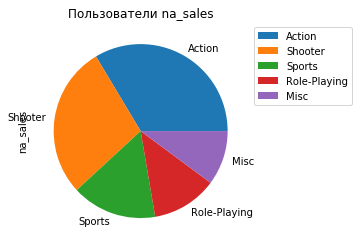

Наиболее популярные жанры:Action,Shooter,Sports,Role-Playing,Misc



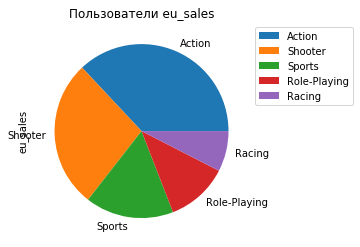

Наиболее популярные жанры:Action,Shooter,Sports,Role-Playing,Racing



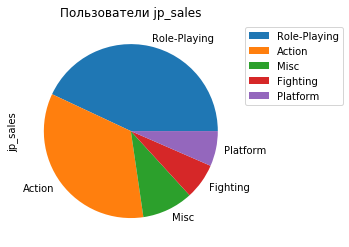

Наиболее популярные жанры:Role-Playing,Action,Misc,Fighting,Platform



In [51]:
# По каждой стране 
# группируем данные по наименованию жанра, подсчитываем для каждого жанра продажу в стране, сорттируем данные
# по убыванию продаж. Сохраняем топ-5 строк.
for user in user_data:
    user_genre_data = actual_games_data[['genre',user]]
   
    user_genre_data = user_genre_data.pivot_table(index='genre',
                                          values=user,aggfunc='sum').sort_values(by=user,ascending=False).head()
    
    user_genre_data.plot(y=user,kind='pie') # построение круговой диаграммы
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Пользователи '+user)
    plt.show()
    
    #print(user_genre_data)
    print('Наиболее популярные жанры:'+user_genre_data.index[0]+','+user_genre_data.index[1]+','+user_genre_data.index[2]
         +','+user_genre_data.index[3]+','+user_genre_data.index[4])
    print()


Заметим, что предпочтения Северной Америки и Европы более схожи, чем с Японией. Возможно это из-за территориально-исторической составляющей той или иной страны и менталитета жителей. В Северной Америке и Европе часто происходили военно-боевые конфликты, отсюда и предпочтения. Япония более филосовская страна.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Посмотрим какие игры наиболее востребованы в каждом рассматриваемом регионе.

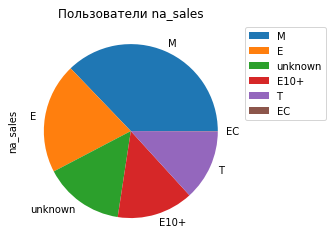

Наиболее популярные рейтинги игр:M,E,unknown,E10+,T



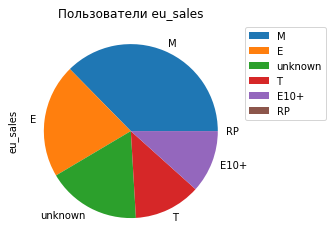

Наиболее популярные рейтинги игр:M,E,unknown,T,E10+



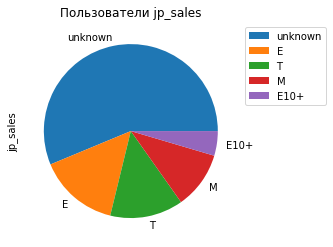

Наиболее популярные рейтинги игр:unknown,E,T,M,E10+



In [52]:
for user in user_data:
    user_esrb_data = actual_games_data[['rating',user]]
   
    user_esrb_data = user_esrb_data.pivot_table(index='rating',
                                          values=user,aggfunc='sum').sort_values(by=user,ascending=False)
    
    user_esrb_data.plot(y=user,kind='pie') # построение круговой диаграммы
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Пользователи '+user)
    plt.show()
    
    #print(user_genre_data)
    print('Наиболее популярные рейтинги игр:'+user_esrb_data.index[0]+','+user_esrb_data.index[1]+
          ','+user_esrb_data.index[2]+','+user_esrb_data.index[3]+','+user_esrb_data.index[4])
    print()

Как видно из графиков, в представленных данных очень много пропусков (отсутствие рейтинга - значение unknown). 

Самые большие продажи игр в Северной Америке и Европе совпадают:
«M» — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет; 
«E» — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет и старше.

Самые большие продажи игр в Японии:
«E» — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет и старше;
«T» — «Подросткам»: Игра подходит для лиц от 13 лет и старше.

Игры, отнесенные к 
«EC» — «Для детей младшего возраста»: Игра подходит для детей от 3 лет;
«AO» — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет;
практически отсутствуют во всех странах.

# Шаг 5. Проверка гипотез  <a id='hypothesis'></a>

## Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые


Рассмотрим общие данные о средних пользовательских рейтингах по платформам. Создадим две таблицы.

In [53]:
XOne_data = actual_games_data.query('platform=="XOne"')
PC_data = actual_games_data.query('platform=="PC"') 

Удалим строки с пропусками в полученных таблицах, для корректного проведения стат-теста.

In [54]:
#удаление строк с пропусками
XOne_data.dropna(subset=['user_score'],inplace=True)
PC_data.dropna(subset=['user_score'],inplace=True)

In [55]:
# проверка, что нет пропусков
print(XOne_data['user_score'].isnull().sum())
print(PC_data['user_score'].isnull().sum())

0
0


In [56]:
#Числовое описание данных для столбца user_score платформы Xbox One
XOne_data['user_score'].describe()

count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

In [57]:
#Числовое описание данных для столбца user_score платформы PC
PC_data['user_score'].describe()

count    307.000000
mean       6.451792
std        1.611303
min        1.400000
25%        5.550000
50%        6.800000
75%        7.700000
max        9.300000
Name: user_score, dtype: float64

Заметим, что средние и медианы тарифов пракически совпадают. Чтобы понять, совпадают ли средние значения пользовательских рейтингов по платформам, недостаточно просто сравнить числа. Без проведения корректного теста нельзя считать совпадение случайным или закономерным.
Вместо расчёта и сравнения самих средних, используются сами датасеты для проведения статистического теста.

Нулевая гипотеза H₀ всегда формулируется так, чтобы использовать знак равенства. Если выясняем, есть ли разница между совокупностями, то нулевая гипотеза будет такая: «нет, разницы нет, то есть исследуемые параметры равны».
Cформулируем нулевую гипотезу H₀:  средние значения пользовательских рейтингов по платформам XOne и PC равны.
Исходя из H₀ формулируется альтернативная гипотеза H₁: средние значения пользовательских рейтингов по платформам XOne и PC отличаются.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применяется метод scipy.stats.ttest_ind (array1, array2, equal_var) .
Методу передают параметры:
•	array1, array2 — массивы, содержащие выборки;
•	equal_var («равная дисперсия») — необязательный параметр, задающий считать ли равными дисперсии выборок. Передаётся как "equal_var = True" или "equal_var = False" (True — считать, False — не считать).

Прежде чем порверить гипотезу H₀, найдем дисперсию среднего значения пользовательских рейтингов по платформам.

In [58]:
print('Дисперсия по платформе XOne =',np.var(XOne_data['user_score'], ddof=1))
print('Дисперсия по платформе PC =',np.var(PC_data['user_score'], ddof=1))

Дисперсия по платформе XOne = 1.9069968429360702
Дисперсия по платформе PC = 2.5962957995358824


Дисперсия отличаются не сильно, следовательно параметр equal_var в статистическом методе scipy.stats.ttest_ind примем равным True.

In [59]:
alpha = 0.05 # критический уровень статистической значимости. Если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(XOne_data['user_score'], PC_data['user_score'])
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.6267602271422398
Не получилось отвергнуть нулевую гипотезу


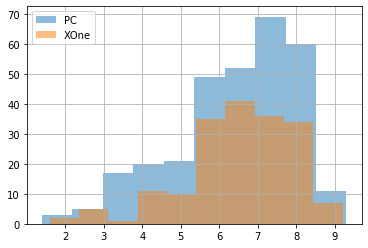

In [60]:
PC_data['user_score'].hist(alpha=0.5,label='PC')
XOne_data['user_score'].hist(alpha=0.5,label='XOne')
plt.legend()
plt.show()

Не получилось отвергнуть нулевую гипотезу, что средние значения пользовательских рейтингов по платформам XOne и PC равны. Полученное значение p-value равно 63%. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними рейтингами.

## Гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.


Рассмотрим общие данные о средних пользовательских рейтингах по жанрам Action (англ. «действие») и Sports (англ. «виды спорта»). Создадим две таблицы.

In [61]:
action_data = actual_games_data.query('genre=="Action"')
sports_data = actual_games_data.query('genre=="Sports"') 

In [62]:
# проверка, что нет пропусков
print(action_data['user_score'].isnull().sum())
print(sports_data['user_score'].isnull().sum())

605
143


Удалим строки с пропусками в полученных таблицах, для корректного проведения стат-теста.

In [63]:
action_data.dropna(subset=['user_score'],inplace=True)
sports_data.dropna(subset=['user_score'],inplace=True)

In [64]:
#Числовое описание данных для столбца user_score жанра action_data
action_data['user_score'].describe()

count    664.000000
mean       6.775904
std        1.346060
min        1.600000
25%        6.100000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64

In [65]:
#Числовое описание данных для столбца user_score жанра action_data
sports_data['user_score'].describe()

count    246.000000
mean       5.650813
std        1.697795
min        0.200000
25%        4.400000
50%        6.000000
75%        6.900000
max        8.800000
Name: user_score, dtype: float64

Средние значения и медианы по жанрам близки, но это малоинформативно. Будем использовать сами датасеты для проведения статистического теста.

Нулевая гипотеза H₀ всегда формулируется так, чтобы использовать знак равенства.
Cформулируем нулевую гипотезу H₀:  средние значения пользовательских рейтингов по жанрам Action и Sports равны.
Исходя из H₀ формулируется альтернативная гипотеза H₁: средние значения пользовательских рейтингов по жанрам Action и Sports  отличаются.

Прежде чем порверить гипотезу H₀, найдем дисперсию среднего значения пользовательских рейтингов по жанрам.

In [66]:
print('Дисперсия по жанру Action =',np.var(action_data['user_score'], ddof=1))
print('Дисперсия по жанру Sports =',np.var(sports_data['user_score'], ddof=1))

Дисперсия по жанру Action = 1.8118770103036566
Дисперсия по жанру Sports = 2.882509540401525


Дисперсия не сильно отличаются, следовательно параметр equal_var в методе scipy.stats.ttest_ind можно принять равным True.

In [67]:
alpha = 0.05 # критический уровень статистической значимости. Если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(action_data['user_score'], sports_data['user_score'])
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.1974550252152054e-24
Отвергаем нулевую гипотезу


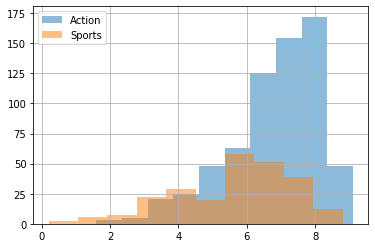

In [68]:
action_data['user_score'].hist(alpha=0.5,label = 'Action')
sports_data['user_score'].hist(alpha=0.5,label='Sports')
plt.legend()
plt.show()

Отвергаем нулевую гипотезу, что средние значения пользовательских рейтингов по жанрам Action и Sports равны. Значит, средние значения пользовательских рейтингов зависят от жанра. 


# Шаг 6. Общий вывод  <a id=''></a>

Проведена предобработка данных. Пропуски в столбцах name, genre, year_of_release были удалены (их процент довольно мал). Пропуски в столбцах critic_score и user_score оставили, так как их очень много. В оценке пользователей user_score встречается значение 'tbd',т.е. оценка только "Будет определена". Эти значения заменили на Nan, чтобы потом со стат-тестами и корреляцией не мешали работать. В столбце рейтинга rating пропуски заменили на специальное значение 'unknown'. Заменили в данных старую аббревиатуру из ESRB К-А на новую Е. Сделали корректную замену типов данных в двух столбцах.

Была подсчитана суммарная продажа во всех регионах. С 2001 года стало выпускаться не менее 444 игр ежегодно. Пик выпуска игр пришолся на 2008 год, после чего наблюдается спад. У любой платформы есть периоды роста, пика и спада продаж. Характерный срок, за который появляются новые и исчезают старые платформы, равен 6 годам.

За актуальный период был принят период с 2011 по 2016 год. Далее анализ строится только за этот период.

По состоянию на 2017 год платформы 'PS4', 'XOne', '3DS', 'PC', 'WiiU' лидируют по продажам. Их можно отнести к потенциально прибыльным платформам. Для платформ PS4 и XOne ранее наблюдался рост продаж. У платформы PC хоть и идет тенденция к спаду за актуальный период, но она самая долгая из топ-платформ, появилась еще в 1985 году, возможно она еще долго продержится на рынке.

В средних продажах на разных платформах, как и в глобальным продажам каждой игры (в которой суммарная продажа больше значения порогового значения) с разбивкой по топ-платформам сохраняется тенденция, что наибольша прибыль у платформы 3DS, затем идет PS4, затем - XOne, затем - PC, в конце - WiiU.

По всем популярным платформам  наблюдается наличие очень малой связи между отзывами критиков и продажами. Т.е. отзывы критиков хоть и влияют на продажи игр, но очень несущественно.
На платформах PS4, XOne, 3DS, PC наблюдается отсутствие связи между отзывами пользователей и продажами. Получается, что отзывы пользователей никак не влияют на продажи игр. А вот на платформе WiiU наблюдается наличие связи между отзывами пользователей и продажами, но довольно небольшое.

Самые распространенные жанры игр это Action	(31.55%), Role-Playing(11.56%), Adventure(10.19%).  Они составляют половину всех игр. Самые прибыльные жанры Shooter, Sports, Platform, Fighting. Жанры с самыми низкими продажами: Adventure, Strategy,Puzzle.


Дополнительно проведены стат-тесты и сделаны следующие выводы:
- средние значения пользовательских рейтингов по платформам XOne и PC равны. Значимых различий между средними рейтингами нет.
- средние значения пользовательских рейтингов зависят от жанра (на примере Action и Sports). 

Если рассматреть пользователей отдельно по каждому региону, то можно сделать следующие выводы.

Наиболее популярные жанры в Северной Америке:Action,Shooter,Sports,Role-Playing,Misc.
Наиболее популярные жанры в Европе:Action,Shooter,Sports,Role-Playing,Racing.
Самые большие продажи игр в Северной Америке и Европе совпадают: «М» - «Для взрослых» и «E» — «Для всех».

Наиболее популярные жанры в Японии:Role-Playing,Action,Misc,Fighting,Platform.
Самые большие продажи игр в Японии «E» — «Для всех» и «T» — «Подросткам».

Заметим, что предпочтения Северной Америки и Европы более схожи, чем с Японией. Возможно это из-за территориально-исторической составляющей страны и менталитета жителей. Игры, отнесенные к «EC» — «Для детей младшего возраста» и «AO» — «Только для взрослых» практически отсутствуют во всех странах.

Итак, в результате анализа выявлено, что отзывы критиков очень мало влияют на  продажи, а отзывы пользователей совсем не влияют на продажи игр. Потенциально прибыльными платформами можно назвать платформы 'PS4', 'XOne', '3DS', 'PC', 'WiiU', которые лидируют по продажам. Успешность игры зависит от ее жанра. Самые прибыльные жанры в целом по миру: Shooter, Sports, Platform, Fighting. Жанры с самыми низкими продажами: Adventure, Strategy,Puzzle. Самые большие продажи по рейтингу ESRB у «М» - «Для взрослых», «E» — «Для всех» и «T» — «Подросткам».